In [2]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats import entropy
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
import re

In [3]:
# Read the data
df = pd.read_csv('processed_data/pa_data_all_elections_sample.csv')
df.head()

,DOB,Registration Date,Voter Status,Status Change Date,Date Last Changed,Gender M,Gender F,Gender U,Party D,Party R,...,Election 01/03/2006 Party R,Election 01/03/2006 Party I,Election 01/03/2006 Voted,Election 01/03/2006 By Mail,Election 09/09/2008 Presence,Election 09/09/2008 Party D,Election 09/09/2008 Party R,Election 09/09/2008 Party I,Election 09/09/2008 Voted,Election 09/09/2008 By Mail
0,0.338,0.845,1,0.845,0.992,1,0,0,0,1,...,NaN,NaN,NaN,NaN,1,0.0,1.0,0.0,1.0,0.0
1,0.449,0.921,1,0.921,0.990,1,0,0,0,1,...,NaN,NaN,NaN,NaN,1,0.0,0.0,1.0,0.0,0.0
2,0.626,0.779,1,0.779,0.992,0,0,1,1,0,...,NaN,NaN,NaN,NaN,1,0.0,0.0,1.0,0.0,0.0
3,0.418,0.678,1,0.678,0.976,0,0,1,0,1,...,NaN,NaN,NaN,NaN,1,0.0,0.0,1.0,0.0,0.0
4,0.406,0.881,1,0.881,0.996,1,0,0,0,1,...,NaN,NaN,NaN,NaN,1,0.0,0.0,1.0,0.0,0.0


In [4]:
# We will look for columns that contain 'Election' to narrow down the search.
election_related_columns = [col for col in df.columns if 'Election' in col]

# Now we will try to extract the date from these column names and check if they are in the first week of May or November.
# The dates are in the format "MM/DD/YYYY".

# Define a regex pattern to match the date format within the column names
date_pattern = re.compile(r'(\d{2})/(\d{2})/(\d{4})')

# Extract date from the column name and check if it's in the first week of May or November
def extract_date_and_check(column_name):
    match = date_pattern.search(column_name)
    if match:
        month, day, year = match.groups()
        if month in ['05', '11'] and 1 <= int(day) <= 7:
            return True
    return False

# Filter the election-related columns based on the date criteria
filtered_election_columns = [col for col in election_related_columns if extract_date_and_check(col)]

# Create a new dataframe with only the filtered columns
df_primary_general_elections = df[filtered_election_columns]

df_primary_general_elections.head()


,Election 11/06/2018 Presence,Election 11/06/2018 Party D,Election 11/06/2018 Party R,Election 11/06/2018 Party I,Election 11/06/2018 Voted,Election 11/06/2018 By Mail,Election 11/05/2019 Presence,Election 11/05/2019 Party D,Election 11/05/2019 Party R,Election 11/05/2019 Party I,...,Election 11/04/2003 Party R,Election 11/04/2003 Party I,Election 11/04/2003 Voted,Election 11/04/2003 By Mail,Election 11/05/2002 Presence,Election 11/05/2002 Party D,Election 11/05/2002 Party R,Election 11/05/2002 Party I,Election 11/05/2002 Voted,Election 11/05/2002 By Mail
0,1,0,0,1,0,0,1,0,0,1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,0,0,1,0,0,1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1,1,0,0,1,0,1,1,0,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1,0,0,1,0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1,0,1,0,1,0,1,0,1,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [5]:
# For some of the EDA, we'd like a dataframe with only the major elections.
# So, we can drop columns under a certain minimum county participation rate (95%).

# Check if the column name fits the criteria and has 1 in 95% of rows
def check_and_delete_columns(df):
    columns_to_drop = []
    for col in df.columns:
        if col.startswith("Election") and col.endswith("Presence"):
            if df[col].mean() < 0.95:
                # Get the index of the current column
                col_index = df.columns.get_loc(col)

                # Append the current column and the next 5 columns to the list
                columns_to_drop.extend(df.columns[col_index:col_index+6])

    # Drop the columns
    df.drop(columns=columns_to_drop, inplace=True)

# Run the function on the dataframe
check_and_delete_columns(df)

df = df.drop(columns=['Election 05/16/2023 Presence', 'Election 05/16/2023 Party D', 'Election 05/16/2023 Party R', 'Election 05/16/2023 Party I', 'Election 05/16/2023 Voted', 'Election 05/16/2023 By Mail'])



In [6]:
for column in df.columns:
    print(column)

DOB
Registration Date
Voter Status
Status Change Date
Date Last Changed
Gender M
Gender F
Gender U
Party D
Party R
Party I
Last Vote Date Presence
Last Vote Date
Election 05/15/2018 Presence
Election 05/15/2018 Party D
Election 05/15/2018 Party R
Election 05/15/2018 Party I
Election 05/15/2018 Voted
Election 05/15/2018 By Mail
Election 11/06/2018 Presence
Election 11/06/2018 Party D
Election 11/06/2018 Party R
Election 11/06/2018 Party I
Election 11/06/2018 Voted
Election 11/06/2018 By Mail
Election 05/21/2019 Presence
Election 05/21/2019 Party D
Election 05/21/2019 Party R
Election 05/21/2019 Party I
Election 05/21/2019 Voted
Election 05/21/2019 By Mail
Election 11/05/2019 Presence
Election 11/05/2019 Party D
Election 11/05/2019 Party R
Election 11/05/2019 Party I
Election 11/05/2019 Voted
Election 11/05/2019 By Mail
Election 06/02/2020 Presence
Election 06/02/2020 Party D
Election 06/02/2020 Party R
Election 06/02/2020 Party I
Election 06/02/2020 Voted
Election 06/02/2020 By Mail
Ele

In [7]:
df.head()

,DOB,Registration Date,Voter Status,Status Change Date,Date Last Changed,Gender M,Gender F,Gender U,Party D,Party R,...,Election 04/26/2016 Party R,Election 04/26/2016 Party I,Election 04/26/2016 Voted,Election 04/26/2016 By Mail,Election 11/08/2016 Presence,Election 11/08/2016 Party D,Election 11/08/2016 Party R,Election 11/08/2016 Party I,Election 11/08/2016 Voted,Election 11/08/2016 By Mail
0,0.338,0.845,1,0.845,0.992,1,0,0,0,1,...,1,0,1,0,1,0,1,0,1,0
1,0.449,0.921,1,0.921,0.990,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,0.626,0.779,1,0.779,0.992,0,0,1,1,0,...,0,0,1,0,1,1,0,0,1,0
3,0.418,0.678,1,0.678,0.976,0,0,1,0,1,...,0,1,0,0,1,0,1,0,1,0
4,0.406,0.881,1,0.881,0.996,1,0,0,0,1,...,1,0,1,0,1,0,1,0,1,0


/var/folders/vt/kcrf6dkn1t91ywvswkws125c0000gn/T/ipykernel_58577/136086374.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  turnout_by_age_group = election_data.groupby('Age Group')['Election 11/08/2022 Voted'].mean().reset_index()
/var/folders/vt/kcrf6dkn1t91ywvswkws125c0000gn/T/ipykernel_58577/136086374.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


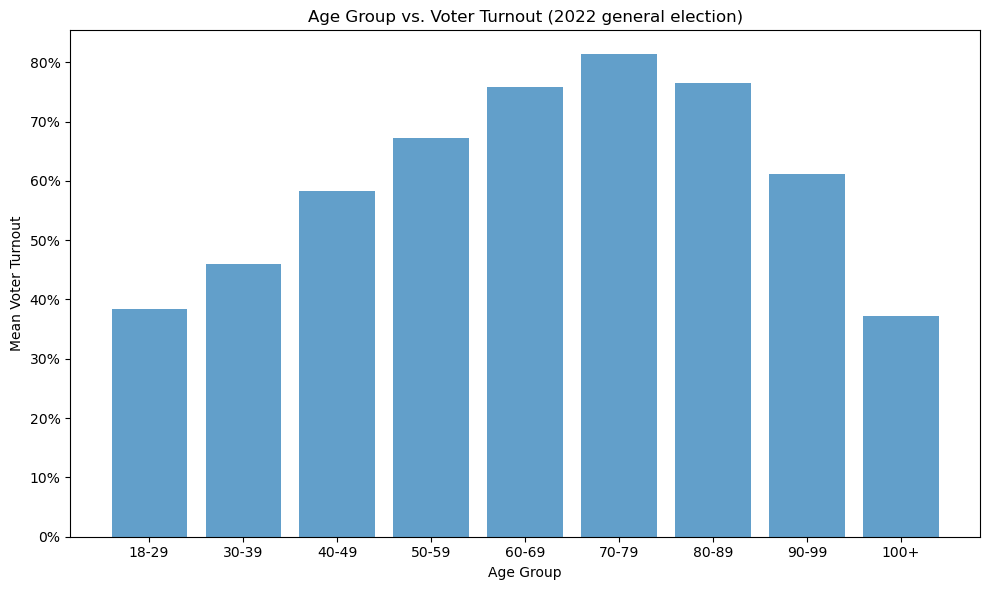

In [8]:
# Define the range of dates corresponding to the normalized DOB values. See `process_data.py` for more details.
start_date = datetime(1900, 1, 1)
end_date = datetime(2023, 11, 10)

# Calculate the total number of days between the start and end dates
total_days = (end_date - start_date).days

# Function to convert normalized DOB to actual age
def convert_normalized_dob_to_age(normalized_dob, total_days, end_date):
    # Calculate the number of days since Jan 1, 1900
    days_since_start = normalized_dob * total_days

    # Calculate the birth date
    birth_date = start_date + timedelta(days=days_since_start)

    # Calculate the age by subtracting the birth year from the current year
    age = end_date.year - birth_date.year - ((end_date.month, end_date.day) < (birth_date.month, birth_date.day))

    return age

# Apply the conversion function to the 'DOB' column
df['Actual Age'] = df['DOB'].apply(convert_normalized_dob_to_age, args=(total_days, end_date))

# Filter out the relevant columns for 'Election 11/08/2022 Voted'
election_data = df[['Actual Age', 'Election 11/08/2022 Voted']].dropna()
election_data['Election 11/08/2022 Voted'] = election_data['Election 11/08/2022 Voted'].astype(int)

# Define the age bins
age_bins = [18, 29, 39, 49, 59, 69, 79, 89, 99, float('inf')]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']

# Assign each voter to an age bin
election_data['Age Group'] = pd.cut(election_data['Actual Age'], bins=age_bins, labels=age_labels, right=False)

# Group the data by the defined age groups and calculate the mean voter turnout for each group
turnout_by_age_group = election_data.groupby('Age Group')['Election 11/08/2022 Voted'].mean().reset_index()

# Create a bar plot to show the relationship between the defined age groups and voter turnout
plt.figure(figsize=(10, 6))
plt.bar(turnout_by_age_group['Age Group'], turnout_by_age_group['Election 11/08/2022 Voted'], alpha=0.7)
plt.title('Age Group vs. Voter Turnout (2022 general election)')
plt.xlabel('Age Group')
plt.ylabel('Mean Voter Turnout')

# Convert the y axis to percentages
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()


/Users/alextonelli/opt/anaconda3/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alextonelli/opt/anaconda3/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alextonelli/opt/anaconda3/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/vt/kcrf6dkn1t91ywvswkws125c0000gn/T/ipykernel_58577/1597535132.py:32: UserWarning: FixedFormatter should only be used together

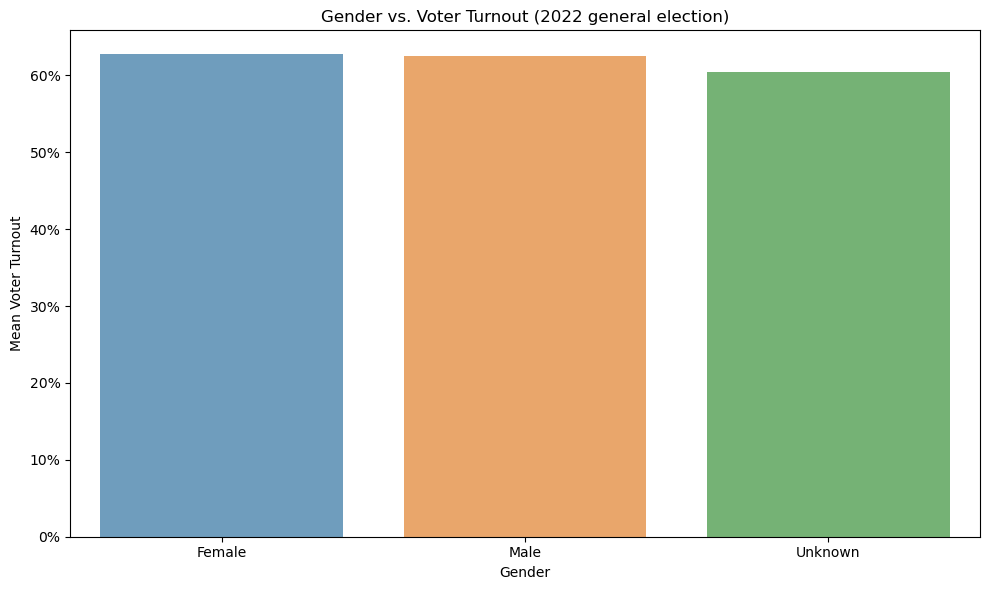

In [9]:
# Specify the exact gender columns if known
gender_columns = ['Gender M', 'Gender F', 'Gender U']

# Filter the dataframe
gender_voting_data = df[gender_columns + ['Election 11/08/2022 Voted']].copy()

# Map the gender columns to a single 'Gender' column using numpy for vectorized operations
conditions = [
    gender_voting_data['Gender M'] == 1,
    gender_voting_data['Gender F'] == 1,
    gender_voting_data['Gender U'] == 1
]
choices = ['Male', 'Female', 'Unknown']
gender_voting_data['Gender'] = np.select(conditions, choices, default='Unknown')

# Drop rows where 'Election 11/08/2022 Voted' is NA
gender_voting_data.dropna(subset=['Election 11/08/2022 Voted'], inplace=True)

# Group by gender and calculate the mean voter turnout
turnout_by_gender = gender_voting_data.groupby('Gender')['Election 11/08/2022 Voted'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='Election 11/08/2022 Voted', data=turnout_by_gender, alpha=0.7)
plt.title('Gender vs. Voter Turnout (2022 general election)')
plt.xlabel('Gender')
plt.ylabel('Mean Voter Turnout')

# Convert the y axis to percentages
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()


/Users/alextonelli/opt/anaconda3/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alextonelli/opt/anaconda3/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alextonelli/opt/anaconda3/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alextonelli/opt/anaconda3/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

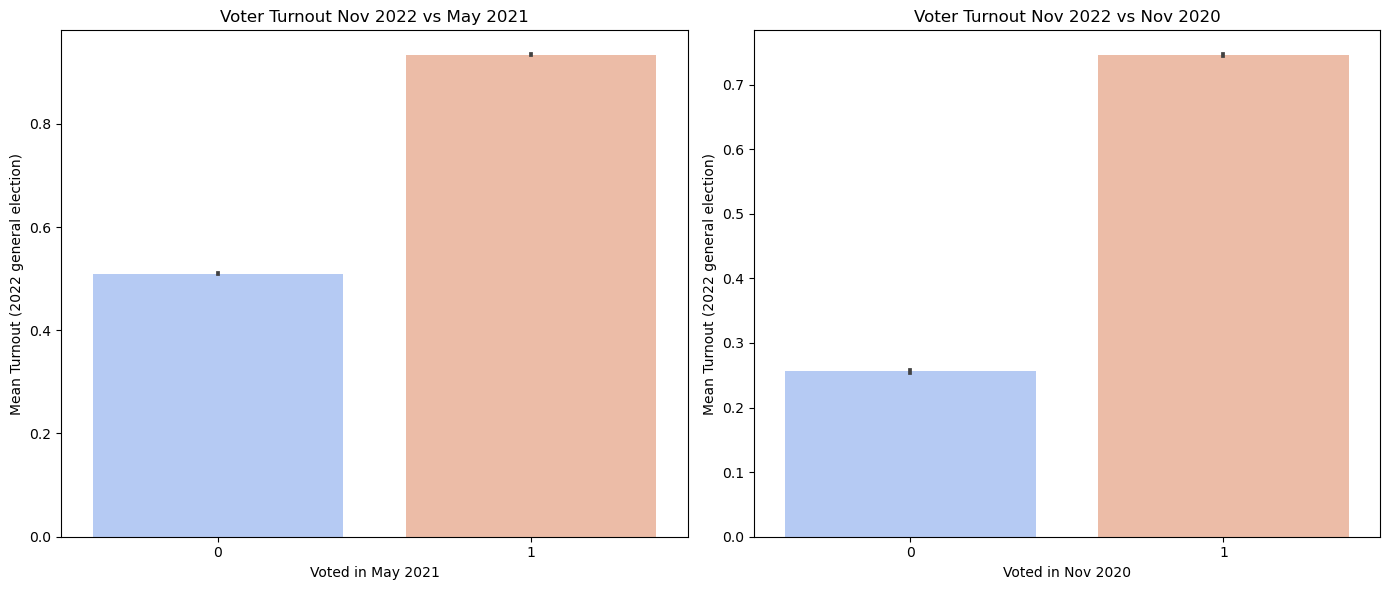

In [10]:
# Check if the necessary columns for previous elections' turnout are present
previous_elections = ['Election 05/18/2021 Voted', 'Election 11/03/2020 Voted']

# Create a new dataframe with the relevant columns
turnout_data = df[previous_elections + ['Election 11/08/2022 Voted']].dropna()

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for May 2021
sns.barplot(
    ax=axes[0],
    x='Election 05/18/2021 Voted',
    y='Election 11/08/2022 Voted',
    data=turnout_data,
    palette='coolwarm'
)
axes[0].set_title('Voter Turnout Nov 2022 vs May 2021')
axes[0].set_xlabel('Voted in May 2021')
axes[0].set_ylabel('Mean Turnout (2022 general election)')

# Plot for November 2020
sns.barplot(
    ax=axes[1],
    x='Election 11/03/2020 Voted',
    y='Election 11/08/2022 Voted',
    data=turnout_data,
    palette='coolwarm'
)
axes[1].set_title('Voter Turnout Nov 2022 vs Nov 2020')
axes[1].set_xlabel('Voted in Nov 2020')
axes[1].set_ylabel('Mean Turnout (2022 general election)')

plt.tight_layout()
plt.show()


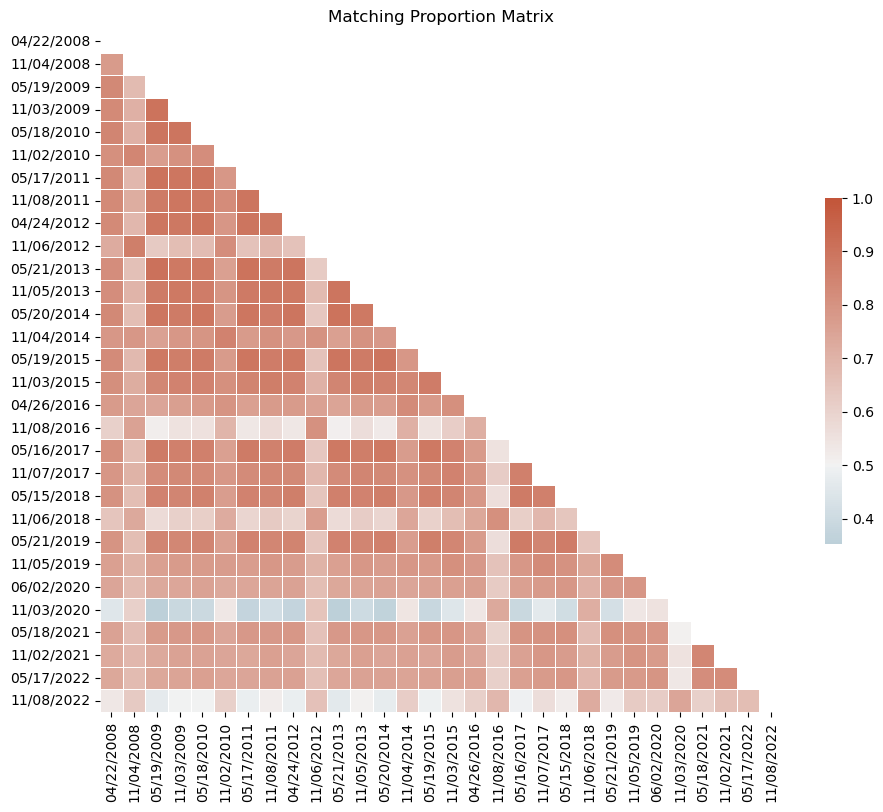

In [11]:
# Take a 10% sample of the data
sample_df = df.sample(frac=0.1, random_state=42)

# Convert vote columns to integers
vote_columns = sample_df.columns[sample_df.columns.str.contains('Voted') & ~sample_df.columns.str.contains('11/08/2022')]
complete_vote_columns = vote_columns[sample_df[vote_columns].notnull().all(axis=0)]
sample_df[complete_vote_columns] = sample_df[complete_vote_columns].fillna(0).astype('Int64')
sample_df['Election 11/08/2022 Voted'] = sample_df['Election 11/08/2022 Voted'].astype('Int64')

# Create a dataframe with only complete vote columns and the target column
vote_data = sample_df[complete_vote_columns.append(pd.Index(['Election 11/08/2022 Voted']))]

# Drop the word election from the column names and the 'Voted' suffix
vote_data.columns = vote_data.columns.str.replace('Election ', '').str.replace(' Voted', '')

# Convert the column names to datetime objects and sort them by date
vote_data.columns = pd.to_datetime(vote_data.columns)
vote_data = vote_data.reindex(sorted(vote_data.columns), axis=1)

# Display only the date
vote_data.columns = vote_data.columns.strftime('%m/%d/%Y')

# Calculate the matching proportion
def calculate_match_proportion(series1, series2):
    return np.mean(series1 == series2)

# Compute the matrix of matching proportions
match_matrix = pd.DataFrame(np.ones((len(vote_data.columns), len(vote_data.columns))), 
                            index=vote_data.columns, columns=vote_data.columns)

# Populate the match_matrix with the matching proportions
for col1 in vote_data.columns:
    for col2 in vote_data.columns:
        match_matrix.loc[col1, col2] = calculate_match_proportion(vote_data[col1], vote_data[col2])

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(match_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Use a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(match_matrix, mask=mask, cmap=cmap, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Matching Proportion Matrix')
plt.show()


(31,)


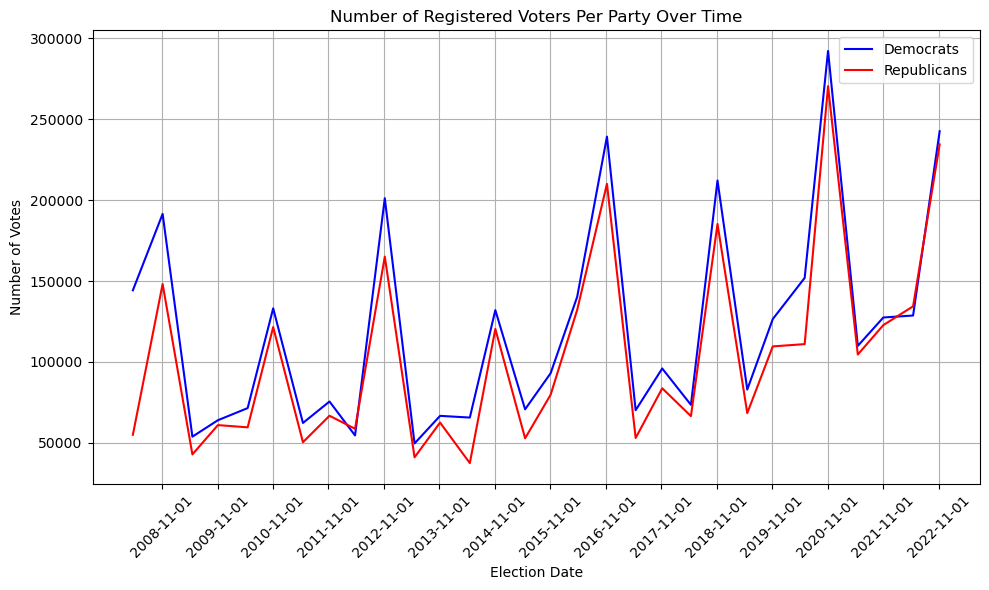

In [28]:
# Identify the columns that contain the voting data for Republicans and Democrats
party_d_cols = df.columns[df.columns.str.contains('Party D')]
party_r_cols = df.columns[df.columns.str.contains('Party R')]

# Initialize lists to store the counts
d_counts = []
r_counts = []

# For each election, count the number of votes for Republicans and Democrats
for d_col, r_col in zip(party_d_cols, party_r_cols):
    d_counts.append(df[d_col].sum())
    r_counts.append(df[r_col].sum())

print(party_d_cols.shape)

# Create a list of election dates
election_dates = [col.split(' ')[1] for col in party_d_cols]

# Remove the first column for election_dates, d_counts, and r_counts
election_dates = election_dates[1:]
d_counts = d_counts[1:]
r_counts = r_counts[1:]

# Convert the election dates to datetime objects and sort the data by dates
election_dates = pd.to_datetime(election_dates)
sorted_indices = election_dates.argsort()

# Sort the data
election_dates = election_dates[sorted_indices]
d_counts = pd.Series(d_counts)[sorted_indices].tolist()
r_counts = pd.Series(r_counts)[sorted_indices].tolist()

# Find the range of years in the election_dates
years_range = range(election_dates.min().year, election_dates.max().year + 1)

# Create a list of datetime objects for November of each year in the range
november_ticks = [pd.to_datetime(f"{year}-11") for year in years_range]

# Plot the counts on a line graph
plt.figure(figsize=(10, 6))
plt.plot(election_dates, d_counts, label='Democrats', color='blue')
plt.plot(election_dates, r_counts, label='Republicans', color='red')
plt.xlabel('Election Date')
plt.ylabel('Number of Votes')
plt.title('Number of Registered Voters Per Party Over Time')
plt.grid()
plt.legend()
plt.xticks(november_ticks, rotation=45)
plt.tight_layout()
plt.show()

30


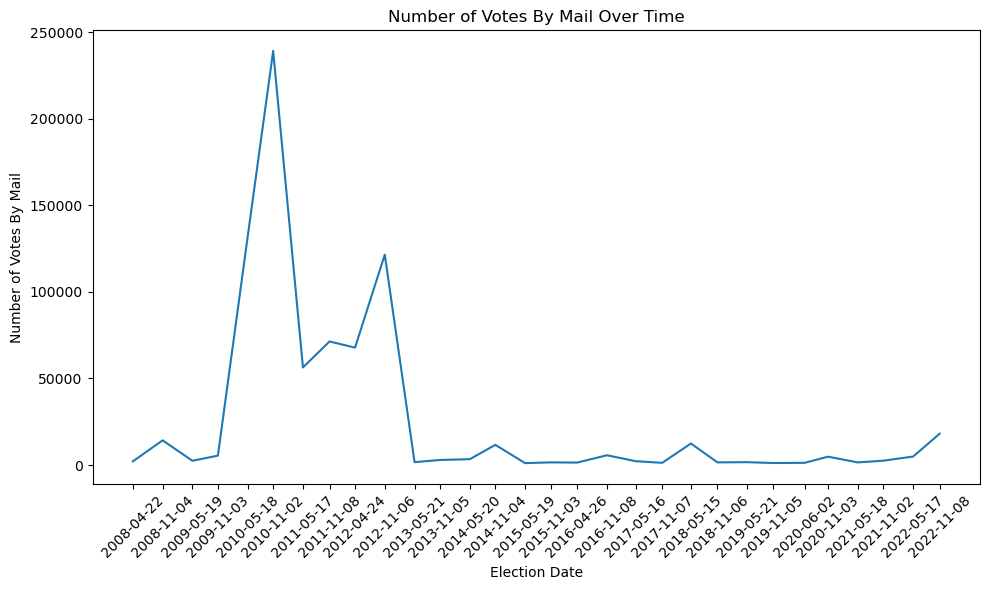

In [19]:
# Identify the columns that contain the vote by mail data
mail_vote_cols = df.columns[df.columns.str.contains('By Mail')]

# Initialize a list to store the counts
mail_vote_counts = []

# For each election, count the number of votes by mail
for col in mail_vote_cols:
    mail_vote_counts.append(df[col].sum())

# Create a list of election dates
election_dates = [col.split(' ')[1] for col in mail_vote_cols]
election_dates = pd.to_datetime(election_dates).sort_values()

# Plot the counts on a line graph
plt.figure(figsize=(10, 6))
plt.plot(election_dates, mail_vote_counts, label='By Mail')
plt.xlabel('Election Date')
plt.ylabel('Number of Votes By Mail')
plt.title('Number of Votes By Mail Over Time')
plt.xticks(election_dates, rotation=45)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/vt/kcrf6dkn1t91ywvswkws125c0000gn/T/ipykernel_58577/560761670.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  percentages_df = pd.concat([percentages_df, new_row])


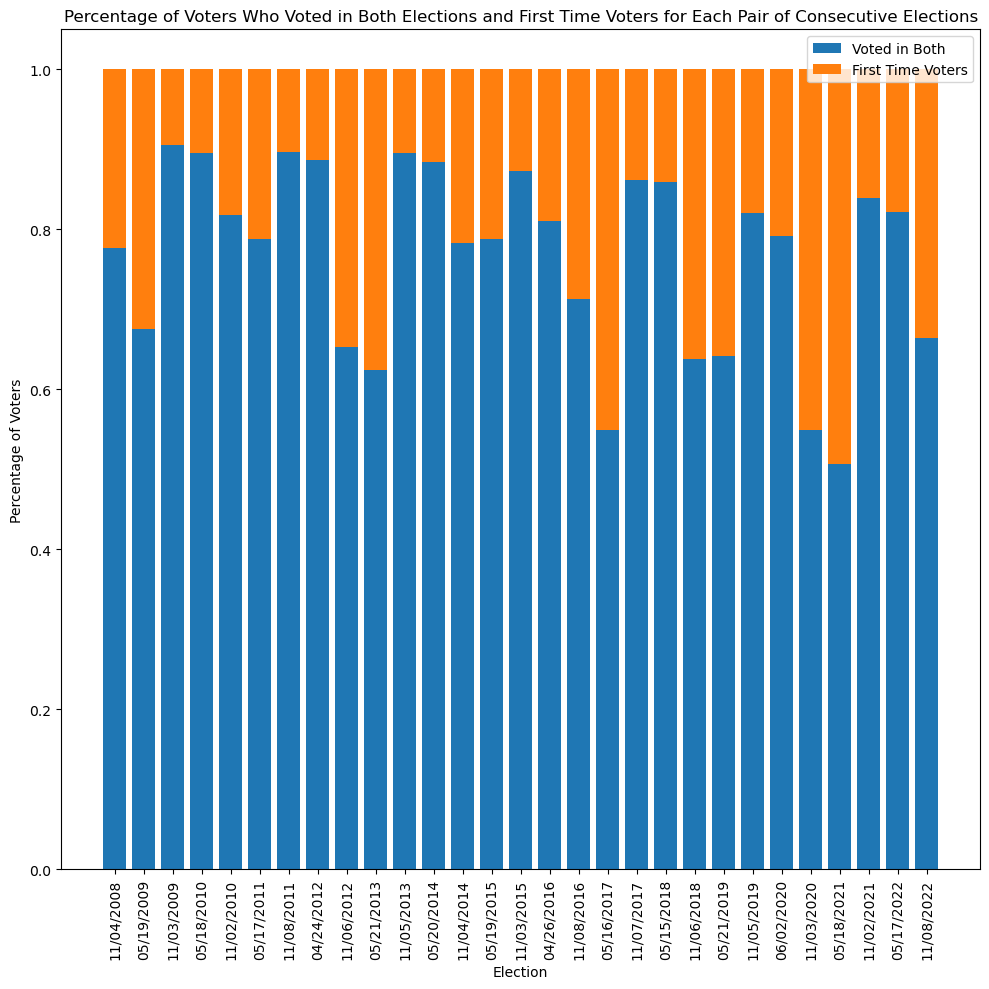

In [14]:
# Initialize a DataFrame to store the percentages
percentages_df = pd.DataFrame(columns=['Election', 'Voted in Both', 'First Time Voters'])

# For each pair of consecutive elections
for i in range(1, len(vote_data.columns)):
    # Calculate the percentage of voters who voted in both the current and the previous election
    voted_in_both = np.mean(vote_data.iloc[:, i] == vote_data.iloc[:, i-1])

    # Calculate the percentage of first-time voters
    first_time_voters = 1 - voted_in_both

    # Append the percentages to the DataFrame
    new_row = pd.DataFrame({
        # Convert the string to a datetime object before calling strftime
        'Election': [datetime.strptime(vote_data.columns[i], '%m/%d/%Y').strftime('%m/%d/%Y')],
        'Voted in Both': [voted_in_both],
        'First Time Voters': [first_time_voters]
    })
    percentages_df = pd.concat([percentages_df, new_row])

# Plot the percentages as a stacked bar graph
plt.figure(figsize=(10, 10))
plt.bar(percentages_df['Election'], percentages_df['Voted in Both'], label='Voted in Both')
plt.bar(percentages_df['Election'], percentages_df['First Time Voters'], bottom=percentages_df['Voted in Both'], label='First Time Voters')
plt.xlabel('Election')
plt.ylabel('Percentage of Voters')
plt.title('Percentage of Voters Who Voted in Both Elections and First Time Voters for Each Pair of Consecutive Elections')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()